In [3]:
import cv2
import pyautogui
from time import time
from math import hypot
import mediapipe as mp
import matplotlib.pyplot as plt

In [4]:
mp_pose = mp.solutions.pose
# for images
pose_image = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5,model_complexity=1)
# for videos
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.7,model_complexity=1,min_tracking_confidence=0.7)
# Intializing mediapipe drawing class
mp_drawing = mp.solutions.drawing_utils

In [5]:
def detectPose(image, pose, draw=False, display=False):
    
    #create copy of input image
    output_image = image.copy()
    
    #convert the image from bgr to rgb
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #perform pose detection
    results = pose.process(imageRGB)
    
    #check if any landmarks are detected and are specified to be drawn
    if results.pose_landmarks and draw:
        
        #draw pose landmarks on the output image
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                 connections=mp_pose.POSE_CONNECTIONS,
                                 landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255),
                                                                             thickness=3,circle_radius=3),
                                 connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
                                                                               thickness=2,circle_radius=2))
    if display:
        
        #displaying input and output image
        plt.figure(figsize=[22,22])
        plt.subplot(121)
        plt.imshow(image[:,:,::-1])
        plt.title("Original Image")
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(output_image[:,:,::-1])
        plt.title("Output Image")
        plt.axis('off')
        
    else:
        return output_image,results


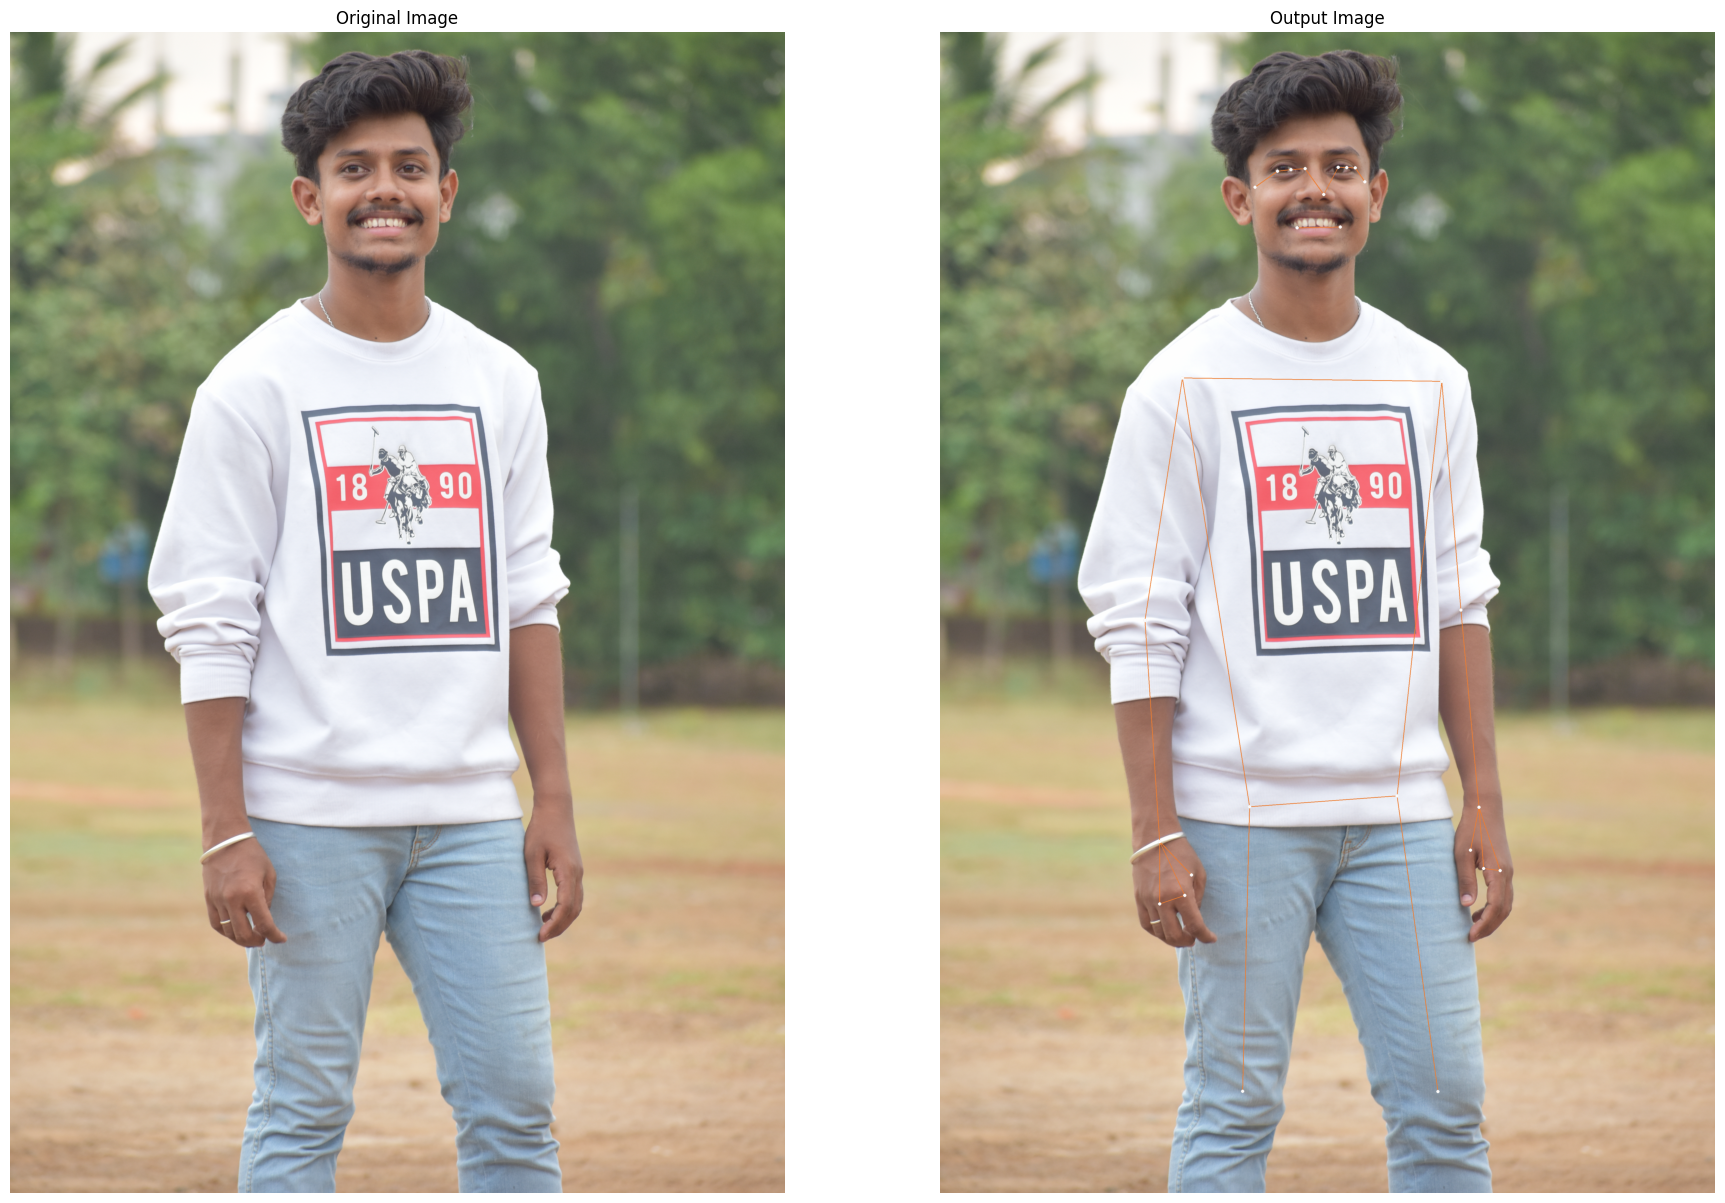

In [6]:
IMG_PATH = "DSC_0703.JPG"
image = cv2.imread(IMG_PATH)
detectPose(image, pose_image, draw=True, display=True)

In [7]:
def checkHandsJoined(image, results, draw=False, display=False):
    
    height, width, _ =image.shape
    output_image = image.copy()
    left_wrist_landmark = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x * width,
                           results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y * height)
    
    right_wrist_landmark = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].x * width,
                           results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].y * height)
    
    euclidean_distance = int(hypot(left_wrist_landmark[0] - right_wrist_landmark[0],
                                  left_wrist_landmark[1] - right_wrist_landmark[1]))
    
    if euclidean_distance < 130:
        
        hand_status = "Hands Joined"
        
        color = (0,255,0)
        
    else:
        hand_status = "Hands Not Joined"
        
        color = (0,0,255)
    
    if draw:
        
        cv2.putText(output_image, hand_status, (10,30), cv2.FONT_HERSHEY_PLAIN, 2, color, 3)
        
        cv2.putText(output_image, f'Distance: {euclidean_distance}', (10,70),
                   cv2.FONT_HERSHEY_PLAIN, 2, color,3)
        
    if display:
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1])
        plt.title("Output image")
        plt.axis('off')
    else:
        return output_image, hand_status

In [8]:
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

cv2.namedWindow('Hands Joined?', cv2.WINDOW_NORMAL)

while camera_video.isOpened():
    
    ok, frame = camera_video.read()
    
    if not ok:
        continue
        
    frame = cv2.flip(frame,1)
    frame_height, frame_width, _ =frame.shape
    frame,results = detectPose(frame,pose_video,draw=True)
    
    if results.pose_landmarks:
        frame, _ =checkHandsJoined(frame,results,draw=True)
    cv2.imshow('Hands Joined?', frame)
    k=cv2.waitKey(1) & 0xFF
    if (k==27):
        break
camera_video.release()
cv2.destroyAllWindows()

In [9]:
def checkLeftRight(image, results, draw=False,display=False):
    
    horizontal_position = None
    
    height, width, _ = image.shape
    
    output_image = image.copy()
    
    left_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * width)
    right_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * width)
    
    if (right_x <=width//2 and left_x<=width//2):
        horizontal_position='Left'
    elif (right_x>=width//2 and left_x>=width//2):
        horizontal_position='Right'
    elif (right_x>=width//2 and left_x<=width//2):
        horizontal_position='Center'
        
    if draw:
        
        cv2.putText(output_image, horizontal_position, (5,height - 10), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 3)
        
        cv2.line(output_image, (width//2,0), (width//2,height),(255,255,255),2)
        
    if display:
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1])
        plt.title("Output image")
        plt.axis('off')
    else:
        return output_image, horizontal_position
        

In [10]:
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

cv2.namedWindow('Horizontal Movements', cv2.WINDOW_NORMAL)

while camera_video.isOpened():
    
    ok, frame = camera_video.read()
    
    if not ok:
        continue
        
    frame = cv2.flip(frame,1)
    frame_height, frame_width, _ =frame.shape
    frame,results = detectPose(frame,pose_video,draw=True)
    
    if results.pose_landmarks:
        frame, _ =checkLeftRight(frame,results,draw=True)
    cv2.imshow('Horizontal Movements', frame)
    k=cv2.waitKey(1) & 0xFF
    if (k==27):
        break
camera_video.release()
cv2.destroyAllWindows()

In [11]:
def checkJumpCrouch(image, results, MID_Y=250, draw=False, display=False):
    height, width, _ = image.shape
    
    output_image = image.copy()
    
    left_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * height)
    right_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * height)
    
    actual_mid_y=abs(right_y + left_y)//2
    
    lower_bound=MID_Y-15
    upper_bound=MID_Y+100
    
    if (actual_mid_y<lower_bound):
        posture = 'Jumping'
    elif (actual_mid_y>upper_bound):
        posture = 'Crouching'
    else:
        posture = 'Standing'
        
    if draw:
        
        cv2.putText(output_image, posture , (5,height - 50), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 3)
        
        cv2.line(output_image, (0,MID_Y), (width,MID_Y),(255,255,255),2)
        
    if display:
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1])
        plt.title("Output image")
        plt.axis('off')
    else:
        return output_image, posture
    

In [12]:
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

cv2.namedWindow('Vertical Movements', cv2.WINDOW_NORMAL)

while camera_video.isOpened():
    
    ok, frame = camera_video.read()
    
    if not ok:
        continue
        
    frame = cv2.flip(frame,1)
    frame_height, frame_width, _ =frame.shape
    frame,results = detectPose(frame,pose_video,draw=True)
    
    if results.pose_landmarks:
        frame, _ =checkJumpCrouch(frame,results,draw=True)
    cv2.imshow('Vertical Movements', frame)
    k=cv2.waitKey(1) & 0xFF
    if (k==27):
        break
camera_video.release()
cv2.destroyAllWindows()

In [14]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)
 
# Create named window for resizing purposes.
cv2.namedWindow('Subway Surfers with Pose Detection', cv2.WINDOW_NORMAL)
# Initialize a variable to store the time of the previous frame.
time1 = 0
 
# Initialize a variable to store the state of the game (started or not).
game_started = False  
 
# Initialize a variable to store the index of the current horizontal position of the person.
# At Start the character is at center so the index is 1 and it can move left (value 0) and right (value 2).
x_pos_index = 1
 
# Initialize a variable to store the index of the current vertical posture of the person.
# At Start the person is standing so the index is 1 and he can crouch (value 0) and jump (value 2).
y_pos_index = 1
 
# Declate a variable to store the intial y-coordinate of the mid-point of both shoulders of the person.
MID_Y = None
 
# Initialize a counter to store count of the number of consecutive frames with person's hands joined.
counter = 0
 
# Initialize the number of consecutive frames on which we want to check if person hands joined before starting the game.
num_of_frames = 10
 
# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Perform the pose detection on the frame.
    frame, results = detectPose(frame, pose_video, draw=game_started)
    
    # Check if the pose landmarks in the frame are detected.
    if results.pose_landmarks:
        
        # Check if the game has started
        if game_started:
            
            # Commands to control the horizontal movements of the character.
            #--------------------------------------------------------------------------------------------------------------
            
            # Get horizontal position of the person in the frame.
            frame, horizontal_position = checkLeftRight(frame, results, draw=True)
            
            # Check if the person has moved to left from center or to center from right.
            if (horizontal_position=='Left' and x_pos_index!=0) or (horizontal_position=='Center' and x_pos_index==2):
                
                # Press the left arrow key.
                pyautogui.press('left')
                
                # Update the horizontal position index of the character.
                x_pos_index -= 1              
 
            # Check if the person has moved to Right from center or to center from left.
            elif (horizontal_position=='Right' and x_pos_index!=2) or (horizontal_position=='Center' and x_pos_index==0):
                
                # Press the right arrow key.
                pyautogui.press('right')
                
                # Update the horizontal position index of the character.
                x_pos_index += 1
            
            #--------------------------------------------------------------------------------------------------------------
        
        # Otherwise if the game has not started    
        else:
            
            # Write the text representing the way to start the game on the frame.
            cv2.putText(frame, 'JOIN BOTH HANDS TO START THE GAME.', (5, frame_height - 10), cv2.FONT_HERSHEY_PLAIN,
                        2, (0, 255, 0), 3)
        
        # Command to Start or resume the game.
        #------------------------------------------------------------------------------------------------------------------
        
        # Check if the left and right hands are joined.
        if checkHandsJoined(frame, results)[1] == 'Hands Joined':
 
            # Increment the count of consecutive frames with +ve condition.
            counter += 1
 
            # Check if the counter is equal to the required number of consecutive frames.  
            if counter == num_of_frames:
 
                # Command to Start the game first time.
                #----------------------------------------------------------------------------------------------------------
                
                # Check if the game has not started yet.
                if not(game_started):
 
                    # Update the value of the variable that stores the game state.
                    game_started = True
 
                    # Retreive the y-coordinate of the left shoulder landmark.
                    left_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * frame_height)
 
                    # Retreive the y-coordinate of the right shoulder landmark.
                    right_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * frame_height)
 
                    # Calculate the intial y-coordinate of the mid-point of both shoulders of the person.
                    MID_Y = abs(right_y + left_y) // 2
 
                    # Move to 1300, 800, then click the left mouse button to start the game.
                    pyautogui.click(x=1300, y=800, button='left')
                
                #----------------------------------------------------------------------------------------------------------
 
                # Command to resume the game after death of the character.
                #----------------------------------------------------------------------------------------------------------
                
                # Otherwise if the game has started.
                else:
 
                    # Press the space key.
                    pyautogui.press('space')
                
                #----------------------------------------------------------------------------------------------------------
                
                # Update the counter value to zero.
                counter = 0
 
        # Otherwise if the left and right hands are not joined.        
        else:
 
            # Update the counter value to zero.
            counter = 0
            
        #------------------------------------------------------------------------------------------------------------------
 
        # Commands to control the vertical movements of the character.
        #------------------------------------------------------------------------------------------------------------------
        
        # Check if the intial y-coordinate of the mid-point of both shoulders of the person has a value.
        if MID_Y:
            
            # Get posture (jumping, crouching or standing) of the person in the frame.
            frame, posture = checkJumpCrouch(frame, results, MID_Y, draw=True)
            
            # Check if the person has jumped.
            if posture == 'Jumping' and y_pos_index == 1:
 
                # Press the up arrow key
                pyautogui.press('up')
                
                # Update the veritcal position index of  the character.
                y_pos_index += 1
 
            # Check if the person has crouched.
            elif posture == 'Crouching' and y_pos_index == 1:
 
                # Press the down arrow key
                pyautogui.press('down')
                
                # Update the veritcal position index of the character.
                y_pos_index -= 1
            
            # Check if the person has stood.
            elif posture == 'Standing' and y_pos_index   != 1:
                
                # Update the veritcal position index of the character.
                y_pos_index = 1
        
        #------------------------------------------------------------------------------------------------------------------
    
    
    # Otherwise if the pose landmarks in the frame are not detected.      
    else:
 
        # Update the counter value to zero.
        counter = 0
        
    # Calculate the frames updates in one second
    #----------------------------------------------------------------------------------------------------------------------
    
    # Set the time for this frame to the current time.
    time2 = time()
    
    # Check if the difference between the previous and this frame time &gt; 0 to avoid division by zero.
    if (time2 - time1) > 0:
    
        # Calculate the number of frames per second.
        frames_per_second = 1.0 / (time2 - time1)
        
        # Write the calculated number of frames per second on the frame.
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    # Update the previous frame time to this frame time.
    # As this frame will become previous frame in next iteration.
    time1 = time2
    
    #----------------------------------------------------------------------------------------------------------------------
    
    # Display the frame.            
    cv2.imshow('Subway Surfers with Pose Detection', frame)
    
    # Wait for 1ms. If a a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF    ;
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break
 
# Release the VideoCapture Object and close the windows.                  
camera_video.release()
cv2.destroyAllWindows()